In [1]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using {device}.')

Using cuda.


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets

In [8]:
# Applying transformations to training data
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
 
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
 
# Loading the CIFAR-10 datasets
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
 
trainloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=64, shuffle=False)


Files already downloaded and verified
Files already downloaded and verified


In [9]:
import torch.nn.functional as F

class IntermediateBlock(nn.Module):
    def __init__(self, in_channels, out_channels, num_convs):
        super(IntermediateBlock, self).__init__()
        # Applying Batch Normalisation , ReLU activation function and Dropout Regularization
        self.convs = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
                nn.Dropout(0.5)
            ) for _ in range(num_convs)
        ])
        # Fully connected layer computes the coefficients for combining conv layer outputs
        self.fc = nn.Linear(in_channels, num_convs) 

    def forward(self, x):
        # Computing mean of each channel of the input image x
        channel_means = torch.mean(x, dim=[2, 3])
        # Applying softmax to convert a vector of real numbers into a probability distribution.
        coefficients = F.softmax(self.fc(channel_means), dim=1)
        # Applying each convolutional layer to the input and combine outputs weighted by 'coefficients'
        outputs = [conv(x) for conv in self.convs]
        scaled_outputs = [coefficients[:, i:i+1, None, None] * output for i, output in enumerate(outputs)]
        x_prime = sum(scaled_outputs)
        return x_prime


In [10]:
class OutputBlock(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(OutputBlock, self).__init__()
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))  # Apply adaptive average pooling
        self.fc = nn.Linear(in_channels, num_classes)  # Fully connected layer for classification

    def forward(self, x):
        x = F.avg_pool2d(x, x.size()[2:]).view(x.size(0), -1)  # Applying global average pooling
        x = x.view(x.size(0), -1)  # Reshaping the tensor
        o = self.fc(x)  # Pass input through the fully connected layer
        return o  # Returning the output logits


In [11]:
class CIFAR10Classifier(nn.Module):
    def __init__(self, num_blocks, num_classes=10, num_convs_per_block=3):
        super(CIFAR10Classifier, self).__init__()
        # Define a sequence of IntermediateBlocks based on the specified number of blocks
        self.blocks = nn.Sequential(
            *[IntermediateBlock(3 if i == 0 else 64, 64, num_convs_per_block) for i in range(num_blocks)]
        )
        # Define the OutputBlock for final classification
        self.output_block = OutputBlock(64, num_classes)

    def forward(self, x):
        x = self.blocks(x)  # Pass the input tensor through the sequence of IntermediateBlocks
        x = self.output_block(x)  # Pass the output through the OutputBlock for final classification
        return x  # Return the final logits


/opt/conda/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1702400440653/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch 1, Loss: 1.669, Training Accuracy: 39.22%, Test Accuracy: 41.33%
Epoch 2, Loss: 1.390, Training Accuracy: 49.88%, Test Accuracy: 50.09%
Epoch 3, Loss: 1.290, Training Accuracy: 53.77%, Test Accuracy: 56.92%
Epoch 4, Loss: 1.212, Training Accuracy: 56.76%, Test Accuracy: 57.47%
Epoch 5, Loss: 1.172, Training Accuracy: 58.25%, Test Accuracy: 55.46%
Epoch 6, Loss: 1.132, Training Accuracy: 59.60%, Test Accuracy: 57.14%
Epoch 7, Loss: 1.098, Training Accuracy: 60.87%, Test Accuracy: 56.65%
Epoch 8, Loss: 1.076, Training Accuracy: 61.80%, Test Accuracy: 61.64%
Epoch 9, Loss: 1.051, Training Accuracy: 63.13%, Test Accuracy: 57.15%
Epoch 10, Loss: 1.033, Training Accuracy: 63.37%, Test Accuracy: 61.01%
Epoch 11, Loss: 1.012, Training Accuracy: 64.35%, Test Accuracy: 64.86%
Epoch 12, Loss: 0.997, Training Accuracy: 64.77%, Test Accuracy: 63.37%
Epoch 13, Loss: 0.980, Training Accuracy: 65.37%, Test Accuracy: 65.10%
Epoch 14, Loss: 0.964, Training Accuracy: 65.95%, Test Accuracy: 67.38%
E

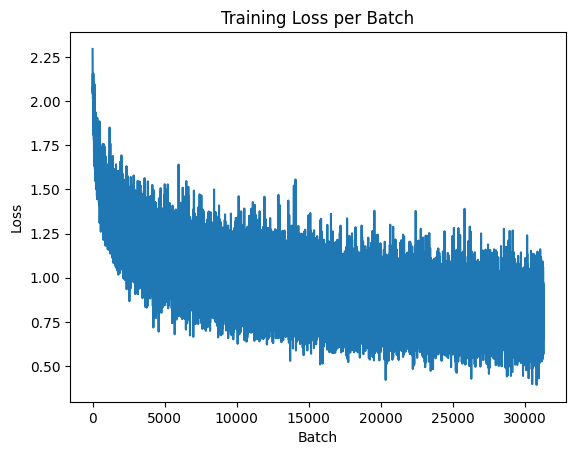

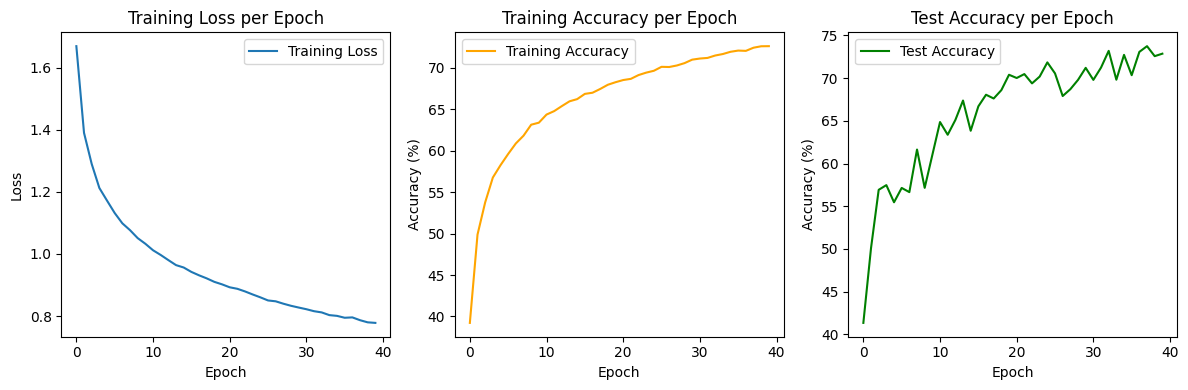

In [12]:
# model architecture with specified number of blocks, classes, and convolution layers per block
model = CIFAR10Classifier(num_blocks=3, num_classes=10, num_convs_per_block=3).to(device)

# optimizer with Adam optimization algorithm and a learning rate of 0.001
optimizer = optim.Adam(model.parameters(), lr=0.001)

# loss function for classification tasks
criterion = nn.CrossEntropyLoss()

def train_and_evaluate(model, trainloader, testloader, criterion, optimizer, epochs=40):
    train_losses = []  # Store training loss for each epoch
    train_accuracies = []  # Store train accuracy for each epoch
    test_accuracies = []  # Store test accuracy for each epoch
    batch_losses = []  # Store losses for each batch

    # Loop through each epoch
    for epoch in range(epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0
        correct = 0
        total = 0

        # Iterate over each batch in the training dataset
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()  # Zero the gradients
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)  # Compute the loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update weights

            running_loss += loss.item()
            batch_losses.append(loss.item())  # Record loss for this batch

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Compute average loss and accuracy for the epoch
        epoch_loss = running_loss / len(trainloader)
        epoch_train_accuracy = 100 * correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_train_accuracy)

        # Evaluation on the test set after each epoch
        test_accuracy = evaluate(model, testloader)
        test_accuracies.append(test_accuracy)

        # Print epoch-wise statistics
        print(f'Epoch {epoch+1}, Loss: {epoch_loss:.3f}, Training Accuracy: {epoch_train_accuracy:.2f}%, Test Accuracy: {test_accuracy:.2f}%')

    # Plot metrics after all epochs are completed
    plot_metrics(train_losses, train_accuracies, test_accuracies, batch_losses)
    return train_losses, train_accuracies, test_accuracies, batch_losses

# Function to evaluate the model on the test set
def evaluate(model, dataloader):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():
        for data in dataloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

# Function to plot training and test metrics
def plot_metrics(train_losses, train_accuracies, test_accuracies, batch_losses):
    # Plot batch losses after all epochs are completed
    plt.plot(batch_losses)
    plt.xlabel('Batch')
    plt.ylabel('Loss')
    plt.title('Training Loss per Batch')
    plt.show()
    
    # Plot training loss, training accuracy, and test accuracy per epoch
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.title('Training Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(train_accuracies, label='Training Accuracy', color='orange')
    plt.title('Training Accuracy per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(test_accuracies, label='Test Accuracy', color='green')
    plt.title('Test Accuracy per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Train the model and evaluate its performance
train_losses, train_accuracies, test_accuracies, batch_loss = train_and_evaluate(model, trainloader, testloader, criterion, optimizer, epochs=40)
